In [ ]:
!nvidia-smi

Tue Sep 13 16:44:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir /root/.kaggle
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle
!kaggle datasets download -d julymarc/agrocode-data-science-cup-2022
!unzip -qq /content/agrocode-data-science-cup-2022.zip

!mkdir weights
!mkdir data
!mkdir data/test
!mkdir data/queries

 94% 193M/205M [00:07<00:00, 30.2MB/s]
100% 205M/205M [00:07<00:00, 27.7MB/s]


In [ ]:
!pip install tfimm
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 155 kB 27.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 28.6 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import os
import shutil
import tensorflow as tf
import tfimm
tf.__version__

'2.8.2'

In [ ]:
print(tfimm.list_models(pretrained="tfimm"))

['cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'convmixer_768_32', 'convmixer_1024_20_ks9_p14', 'convmixer_1536_20', 'convnext_base', 'convnext_base_384_in22ft1k', 'convnext_base_in22ft1k', 'convnext_base_in22k', 'convnext_large', 'convnext_large_384_in22ft1k', 'convnext_large_in22ft1k', 'convnext_large_in22k', 'convnext_small', 'convnext_small_384_in22ft1k', 'convnext_small_in22ft1k', 'convnext_small_in22k', 'convnext_tiny', 'convnext_tiny_384_in22ft1k', 'convnext_tiny_in22ft1k', 'convnext_tiny_in22k', 'convnext_xlarge_384_in22ft1k', 'convnext_xlarge_in22ft1k', 'convnext_xlarge_in22k', 'deit_base_distilled_patch16_224', 'deit_base_distilled_patch16_384', 'deit_base_patch16_224', 'deit_base_patch16_384', 'deit_small_distilled_patch16_224', 'deit_small_patch16_224', 'deit_tiny_distilled_patch16_224', 'deit_tiny_patch16_224', 'ecaresnet26t', 'ecaresnet50d', 'ecaresne

In [ ]:
model = tfimm.create_model("vit_tiny_patch16_224", pretrained="timm", nb_classes=0, model_path='/content/weights/vit_tiny_patch16_224')
model_swin = tfimm.create_model("swin_base_patch4_window7_224", pretrained="timm", nb_classes=0, model_path='/content/weights/swin_base_patch4_window7_224')
# model_swin.save('/content/weights/swin_base_patch4_window7_224')

In [ ]:
model = tfimm.create_model("swin_large_patch4_window7_224_in22k", pretrained="timm", nb_classes=0, model_path='/content/weights/swin_large_patch4_window7_224_in22k')

In [ ]:
preprocess = tfimm.create_preprocessing("swin_large_patch4_window7_224_in22k", dtype="float32")
img = tf.ones((1, 224, 224, 3), dtype="uint8")
img_preprocessed = preprocess(img)

In [ ]:
model.predict(img_preprocessed).shape

(1, 1536)

tfimm swin 384 inference

In [ ]:
model = tfimm.create_model("swin_base_patch4_window12_384", pretrained="timm", nb_classes=0)
model.save('swin_base_patch4_window12_384')
!cp -r ./swin_base_patch4_window12_384 ./weights

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_base_patch4_window12_384_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_base_patch4_window12_384_22kto1k.pth



In [ ]:
!zip -r swin.zip /content/weights/swin_base_patch4_window12_384

  adding: content/weights/swin_base_patch4_window12_384/ (stored 0%)
  adding: content/weights/swin_base_patch4_window12_384/keras_metadata.pb (deflated 96%)
  adding: content/weights/swin_base_patch4_window12_384/variables/ (stored 0%)
  adding: content/weights/swin_base_patch4_window12_384/variables/variables.data-00000-of-00001 (deflated 13%)
  adding: content/weights/swin_base_patch4_window12_384/variables/variables.index (deflated 76%)
  adding: content/weights/swin_base_patch4_window12_384/assets/ (stored 0%)
  adding: content/weights/swin_base_patch4_window12_384/saved_model.pb (deflated 90%)


In [ ]:
import tfimm
import timm

import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import NearestNeighbors

queries = pd.read_csv('./data/queries.csv')
test = pd.read_csv('./data/test.csv')


preprocess = tfimm.create_preprocessing("swin_base_patch4_window12_384", dtype="float32")
model = tfimm.create_model("swin_base_patch4_window12_384", pretrained="timm", nb_classes=0, model_path='/content/weights/swin_base_patch4_window12_384')

def extract_features(path, model=model):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (384, 384))
    x = np.expand_dims(img, axis=0)
    x = preprocess(x)

    feature = model.predict(x, verbose=0)[0]

    return feature / np.linalg.norm(feature)


test_embeddings = []

for idx in tqdm(test.idx):
    test_embeddings.append(extract_features(f'./data/test/{idx}.png'))

test_embeddings = np.array(test_embeddings)

queries_embeddings = []

for idx in tqdm(queries.idx):
    queries_embeddings.append(extract_features(f'./data/queries/{idx}.png'))

queries_embeddings = np.array(queries_embeddings)

neigh = NearestNeighbors(n_neighbors=10, metric='cosine')
neigh.fit(test_embeddings)

distances, idxs = neigh.kneighbors(queries_embeddings, 10, return_distance=True)

pred_data = pd.DataFrame()
distances = 1 - distances
pred_data['score'] = distances.flatten()

pred_data['database_idx'] = [test.idx.iloc[x] for x in idxs.flatten()]
pred_data.loc[:, 'query_idx'] = np.repeat(queries.idx, 10).values

pred_data.to_csv('./data/submission.csv', index=False)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

timm

In [ ]:
import timm
import torch
print(timm.list_models(pretrained="timm"))

['adv_inception_v3', 'bat_resnext26ts', 'beit_base_patch16_224', 'beit_base_patch16_224_in22k', 'beit_base_patch16_384', 'beit_large_patch16_224', 'beit_large_patch16_224_in22k', 'beit_large_patch16_384', 'beit_large_patch16_512', 'botnet26t_256', 'cait_m36_384', 'cait_m48_448', 'cait_s24_224', 'cait_s24_384', 'cait_s36_384', 'cait_xs24_384', 'cait_xxs24_224', 'cait_xxs24_384', 'cait_xxs36_224', 'cait_xxs36_384', 'coat_lite_mini', 'coat_lite_small', 'coat_lite_tiny', 'coat_mini', 'coat_tiny', 'convit_base', 'convit_small', 'convit_tiny', 'convmixer_768_32', 'convmixer_1024_20_ks9_p14', 'convmixer_1536_20', 'convnext_base', 'convnext_base_384_in22ft1k', 'convnext_base_in22ft1k', 'convnext_base_in22k', 'convnext_large', 'convnext_large_384_in22ft1k', 'convnext_large_in22ft1k', 'convnext_large_in22k', 'convnext_nano', 'convnext_small', 'convnext_small_384_in22ft1k', 'convnext_small_in22ft1k', 'convnext_small_in22k', 'convnext_tiny', 'convnext_tiny_384_in22ft1k', 'convnext_tiny_hnf', 'conv

In [ ]:
model = timm.create_model('beit_base_patch16_384', pretrained=True, num_classes=0)
torch.save(model.state_dict(), './weights/beit_base_patch16_384.zip')
model.load_state_dict(torch.load('./beit_base_patch16_384.zip'))

<All keys matched successfully>

In [ ]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform
from PIL import Image
import torch

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

In [ ]:
img = Image.open('/content/data/test/1006.png').convert('RGB')
img = img.resize((384, 384))

tensor = transform(img).unsqueeze(0)

with torch.no_grad():
    out = model(tensor)
    
torch.squeeze(out).numpy().shape

(768,)

In [ ]:
train = pd.read_csv('train.csv')
test = train.sample(frac=0.01, random_state=41)
test.to_csv('./data/test.csv', index=False)
queries = train.sample(frac=0.01, random_state=42)
queries = queries[['idx']]
queries.to_csv('./data/queries.csv')

for idx in test['idx'].values:
    shutil.copy(f'./train/train/{idx}.png', './data/test')
for idx in queries['idx'].values:
    shutil.copy(f'./train/train/{idx}.png', './data/queries')

In [ ]:
# model.save('/content/weights/vit_tiny_patch16_224')
# loaded_model = tf.keras.models.load_model("/content/weights/vit_tiny_patch16_224")

In [ ]:
# !cp /content/weights/beit_base_patch16_384.zip /content/drive/MyDrive

Inference timm

In [ ]:
import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

from PIL import Image

import torch

import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import NearestNeighbors

queries = pd.read_csv('./data/queries.csv')
test = pd.read_csv('./data/test.csv')


model = timm.create_model('beit_base_patch16_384', pretrained=False, num_classes=0)
model.load_state_dict(torch.load('./weights/beit_base_patch16_384.zip'))

# model = timm.create_model('beit_base_patch16_384', pretrained=True, num_classes=0) # beit_base_patch16_224_in22k beit_base_patch16_224 beit_base_patch16_384 beit_large_patch16_384

config = resolve_data_config({}, model=model)
transform = create_transform(**config)


def extract_features(path, model=model):
    img = Image.open(path).convert('RGB')
    # img = img.resize((384, 384))

    tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        out = model(tensor)
        
    feature = torch.squeeze(out).numpy()

    return feature / np.linalg.norm(feature)


test_embeddings = []

for idx in tqdm(test.idx):
    test_embeddings.append(extract_features(f'./data/test/{idx}.png'))

test_embeddings = np.array(test_embeddings)

queries_embeddings = []

for idx in tqdm(queries.idx):
    queries_embeddings.append(extract_features(f'./data/queries/{idx}.png'))

queries_embeddings = np.array(queries_embeddings)

neigh = NearestNeighbors(n_neighbors=10, metric='cosine')
neigh.fit(test_embeddings)

distances, idxs = neigh.kneighbors(queries_embeddings, 10, return_distance=True)

pred_data = pd.DataFrame()
distances = 1 - distances
pred_data['score'] = distances.flatten()

pred_data['database_idx'] = [test.idx.iloc[x] for x in idxs.flatten()]
pred_data.loc[:, 'query_idx'] = np.repeat(queries.idx, 10).values

pred_data.to_csv('./data/submission.csv', index=False)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
# pred_data.sort_values(by='score', ascending=False).groupby(['query_idx']).head(1)
pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False)

,score,database_idx
query_idx,,
6296,1.000000,4588
5654,0.907516,4286
2585,0.853492,3042
3932,0.841314,3042
894,0.823452,7237
7262,0.778010,225
6079,0.760758,225
4865,0.744096,3075
3834,0.727724,3447


In [ ]:
idx_f = 6079
pred_data[pred_data.query_idx == idx_f]

,score,database_idx,query_idx
360,0.760758,225,6079
361,0.578773,5859,6079
362,0.451129,2821,6079
363,0.446641,6118,6079
364,0.410044,4691,6079
365,0.388448,5070,6079
366,0.356375,1237,6079
367,0.326815,1708,6079
368,0.323486,6073,6079
369,0.294003,3075,6079


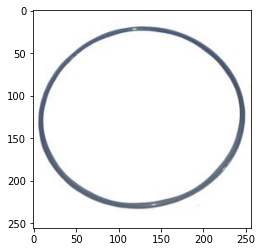

candidates:
score: [0.76075804]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


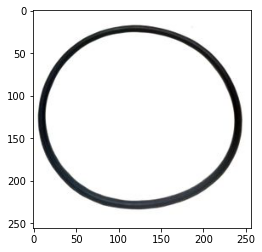

score: [0.57877296]


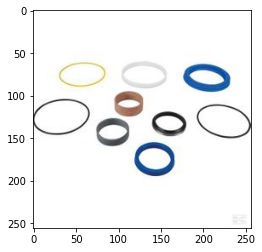

score: [0.45112896]


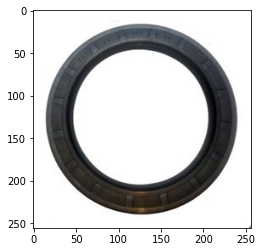

score: [0.4466412]


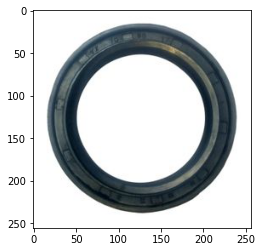

score: [0.41004384]


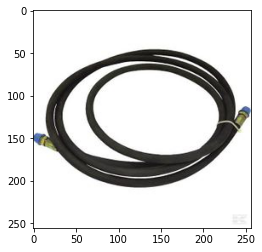

score: [0.38844788]


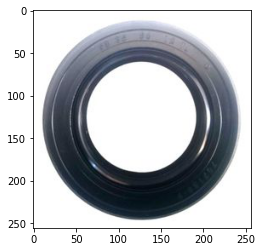

score: [0.35637546]


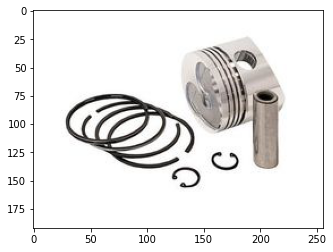

score: [0.3268146]


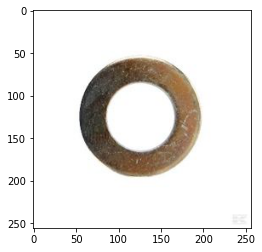

score: [0.3234862]


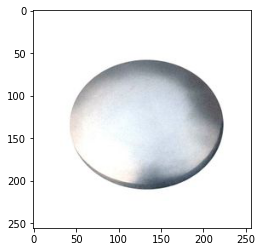

score: [0.29400277]


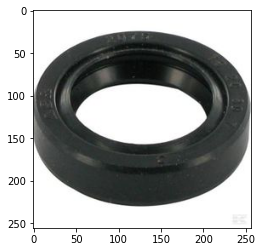

In [ ]:
import matplotlib.pyplot as plt

img_path = f'./train/train/{idx_f}.png'
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.show()
print('candidates:')

idx_s = pred_data[pred_data.query_idx == idx_f]['database_idx'].values

for i in idx_s:
    img_path = f'./train/train/{i}.png'
    img2 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    print(f'score: {pred_data[pred_data.query_idx == idx_f][pred_data["database_idx"] == i]["score"].values}')
    plt.imshow(img2)
    plt.show()

In [ ]:
# distances

In [ ]:
index_v = 1
first_v = pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False).index[index_v]
second_v = pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False).iloc[index_v, 1]

In [ ]:
# second_v = pred_data.groupby(['query_idx']).agg({'score': np.max, 'database_idx': 'first'}).sort_values(by='score', ascending=False).index[4]]['database_idx'].iloc[2]

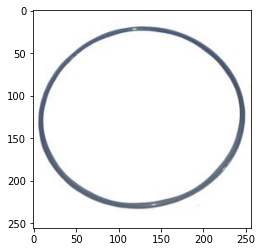

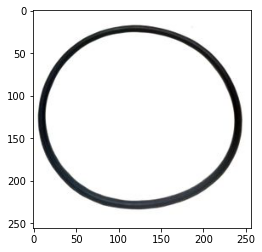

In [ ]:
import matplotlib.pyplot as plt

img_path = f'./train/train/{first_v}.png'
img1 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

img_path = f'./train/train/{second_v}.png'
img2 = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()

Inference

In [ ]:
import tfimm
import timm

import cv2
import numpy as np
import pandas as pd
from glob import glob
from tqdm.auto import tqdm
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
import os
from sklearn.neighbors import NearestNeighbors

queries = pd.read_csv('./data/queries.csv')
# train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')


# preprocess = tfimm.create_preprocessing("vit_tiny_patch16_224", dtype="float32")
preprocess = tfimm.create_preprocessing("swin_large_patch4_window7_224_in22k", dtype="float32")

# model = tfimm.create_model("vit_tiny_patch16_224", pretrained="timm", nb_classes=0, model_path='/content/weights/vit_tiny_patch16_224')
model = tfimm.create_model("swin_large_patch4_window7_224_in22k", pretrained="timm", nb_classes=0, model_path='/content/weights/swin_large_patch4_window7_224_in22k')

def extract_features(path, model=model):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    x = np.expand_dims(img, axis=0)
    x = preprocess(x)

    feature = model.predict(x, verbose=0)[0]

    return feature / np.linalg.norm(feature)


test_embeddings = []

for idx in tqdm(test.idx):
    test_embeddings.append(extract_features(f'./data/test/{idx}.png'))

test_embeddings = np.array(test_embeddings)

queries_embeddings = []

for idx in tqdm(queries.idx):
    queries_embeddings.append(extract_features(f'./data/queries/{idx}.png'))

queries_embeddings = np.array(queries_embeddings)

neigh = NearestNeighbors(n_neighbors=10, metric='cosine')
neigh.fit(test_embeddings)

distances, idxs = neigh.kneighbors(queries_embeddings, 10, return_distance=True)

pred_data = pd.DataFrame()
distances = 1 - distances
pred_data['score'] = distances.flatten()

pred_data['database_idx'] = [test.idx.iloc[x] for x in idxs.flatten()]
pred_data.loc[:, 'query_idx'] = np.repeat(queries.idx, 10).values

pred_data.to_csv('./data/submission.csv', index=False)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [ ]:
pred_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490 entries, 0 to 489
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   score         490 non-null    float32
 1   database_idx  490 non-null    int64  
 2   query_idx     490 non-null    int64  
dtypes: float32(1), int64(2)
memory usage: 9.7 KB


In [ ]:
pred_data[pred_data.score > 0.7]

,score,database_idx,query_idx
20,0.707270,3075,4865
170,0.773242,3042,2585
200,1.000000,4588,6296
250,0.739808,4286,3932
251,0.720176,3042,3932
290,0.770927,7237,894
340,0.852144,4286,5654
341,0.782577,3447,5654
342,0.740937,3042,5654
360,0.827210,225,6079


In [ ]:
!zip -r /content/weights/weights.zip /content/weights/swin_large_patch4_window7_224_in22k/

  adding: content/weights/swin_large_patch4_window7_224_in22k/ (stored 0%)
  adding: content/weights/swin_large_patch4_window7_224_in22k/keras_metadata.pb (deflated 96%)
  adding: content/weights/swin_large_patch4_window7_224_in22k/saved_model.pb (deflated 90%)
  adding: content/weights/swin_large_patch4_window7_224_in22k/variables/ (stored 0%)
  adding: content/weights/swin_large_patch4_window7_224_in22k/variables/variables.index (deflated 75%)
  adding: content/weights/swin_large_patch4_window7_224_in22k/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/weights/swin_large_patch4_window7_224_in22k/assets/ (stored 0%)
  adding: content/weights/swin_large_patch4_window7_224_in22k/dataset-metadata.json (deflated 25%)


In [ ]:
!kaggle datasets init -p  /content/weights/swin_large_patch4_window7_224_in22k

Data package template written to: /content/weights/swin_large_patch4_window7_224_in22k/dataset-metadata.json


In [ ]:
!kaggle datasets create -p /content/weights/swin_large_patch4_window7_224_in22k --dir-mode zip

Starting upload for file keras_metadata.pb
100% 232k/232k [00:07<00:00, 31.5kB/s]
Upload successful: keras_metadata.pb (232KB)
Starting upload for file saved_model.pb
100% 9.85M/9.85M [00:06<00:00, 1.55MB/s]
Upload successful: saved_model.pb (10MB)
Starting upload for file variables.zip
100% 690M/690M [00:48<00:00, 14.8MB/s]
Upload successful: variables.zip (690MB)
Starting upload for file assets.zip
100% 22.0/22.0 [00:03<00:00, 5.71B/s]
Upload successful: assets.zip (22B)
Your private Dataset is being created. Please check progress at https://www.kaggle.com/datasets/dimka11/swin-large-weights
